In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm

from src.data.utils.eeg import get_raw

# we define the annotations from the two datasets we want to use
from src.data.conf.eeg_annotations import braincapture_annotations

from src.data.processing import load_data_dict, get_data

In [2]:
import logging

# Suppress logger messages from MNE-Python
mne_logger = logging.getLogger('mne')
mne_logger.setLevel(logging.ERROR)

## The Structure of the BrainCapture Data

Let's start by fetching some BrainCapture data. We define the path to the GCP bucket and inspect the contents.

In [3]:
braincapture_data_folder = r'C:/Users/wille/OneDrive - Danmarks Tekniske Universitet/Dokumenter/0. Thesis/trustworthy-causal-ai/data/hackathon 01/BC Bhutan/v4.0/'

subject_folders = os.listdir(braincapture_data_folder)
number_files = np.sum([len(os.listdir(braincapture_data_folder + folder)) for folder in subject_folders])

print('The BrainCapture dataset contains', len(subject_folders), 'subject folders and', number_files, 'files!')

The BrainCapture dataset contains 133 subject folders and 136 files!


We now look at a specific EDF file, that is, one recording for one subject. EDF is the format in which the EEG data is stored. One EDF file corresponds to one EEG recording. The EDF files can be found in the provided GCP bucket following the structure:

```.
├── BrainCapture Dataset
│   ├── S001
│   │   └── S001R01.edf
│   ├── S002
│   │   └── S002R01.edf
│   └── ...
└── TUH Dataset
```

## Inspecting the EEG data

We define the path for the specific file. Then, we call the function **get_raw** to extract the EEG data from the EDF file. At the same time, we perform preprocessing on the data. This includes standard signal processing filters and choosing the right EEG electrode channels.

**NB: If you are interested in the preprocessing steps, have a look at src.data.utils.eeg.py**

In [4]:
subject = 'S001'
session = 'R01'

example_file = braincapture_data_folder + f'{subject}/{subject}{session}.edf'

raw = get_raw(example_file)
raw

<RawArray | 20 x 478208 (1868.0 s), ~73.0 MB, data loaded>

The **raw object** contains the EEG data as well as meta data related to the recording such as number of channels, sampling frequency, and band pass filters (see https://en.wikipedia.org/wiki/Band-pass_filter). EEG data consists of the electrical brainwave signals collected at different locations on the scalp of the head. We describe these different signals as channels. the **raw object** contains a lot of interesting information about the recording. For example, the channel names or types can be extracted:

In [5]:
print('Channel names: \n', raw.info['ch_names'])
print('Channel types: \n', raw.get_channel_types())

Channel names: 
 ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2', 'scaling']
Channel types: 
 ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'misc']


We see that most of the channels contain EEG data while the last channel is used for scaling. We can use the Python library **MNE** to manipulate raw objects and to visualise properties of EEG recordings. Here, we look at the placement of the 19 EEG electrodes:

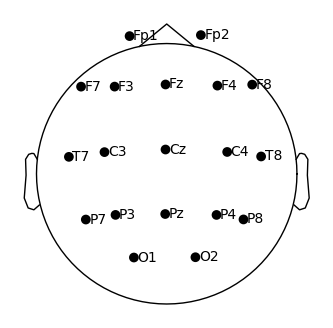

In [6]:
import mne
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
mne.viz.plot_sensors(raw.info, show_names=True, axes=ax);

The electrodes follow the standard 1020 configuration (see: https://en.wikipedia.org/wiki/10%E2%80%9320_system_(EEG)). For further inspection of the EEG signals, we recommend opening the EDF files in the EDFbrowser application - please ask for guidance.

## Loading the Entire Dataset

To load the entire BrainCapture dataset, we use **load_data_dict**. This function loads every EDF files in the dataset using **get_raw** and when **labels = True**, extracts the annotations from the EDf file. The reason we store the data in a dictionary is to maintain subject level information. This is useful if we wish to perform (leave-subject(s)-out) cross-validation at a later point.

In [7]:
data_dict = load_data_dict(data_folder_path=braincapture_data_folder, annotation_dict=braincapture_annotations, tmin=-0.5, tlen=6, labels=True)

  0%|          | 0/133 [00:00<?, ?it/s]

Using data from preloaded Raw for 5 events and 1537 original time points ...
0 bad epochs dropped


  1%|          | 1/133 [00:01<02:21,  1.07s/it]

Using data from preloaded Raw for 6 events and 1537 original time points ...
0 bad epochs dropped


  2%|▏         | 2/133 [00:02<02:21,  1.08s/it]

Using data from preloaded Raw for 6 events and 1537 original time points ...
0 bad epochs dropped


  2%|▏         | 3/133 [00:03<02:22,  1.10s/it]

Using data from preloaded Raw for 6 events and 1537 original time points ...
0 bad epochs dropped


  3%|▎         | 4/133 [00:04<02:26,  1.14s/it]

The **load_data_dict** allows for data extraction with (**labels = True**) or without (**labels == False**, default) labels. If **labels = True**, we need to provide **annotation_dict** containing information about the annotations that we want to extract as labels. In the beginning of the script, we import **braincapture_annotations** that contain a dict of the annotations that are present in the BrainCapture dataset.